In [1]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

/home/s0001900/dev/neurad-studio


In [102]:
import torch
from torch import nn
from pathlib import Path
from nerfstudio.models.diffusion import SDPipe, read_yaml, read_image
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as tvtf

from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure


cp_path = Path("/home/s0001900/dev/checkpoints/finetune/sd2_1/322198/checkpoint-124950/pytorch_lora_weights.safetensors")
diffusion_config_path = Path("configs/diffusion_model_configs.yml")

diff_config = read_yaml(diffusion_config_path)

In [58]:
pipe = SDPipe({
    "model_name": "sd_base",
    "model_id": "stabilityai/stable-diffusion-2-1",
    "low_mem_mode": True,
    "compile_model": False,
    "lora_weights": cp_path,
    #"lora_weights": None,
})

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([3, 512, 512])


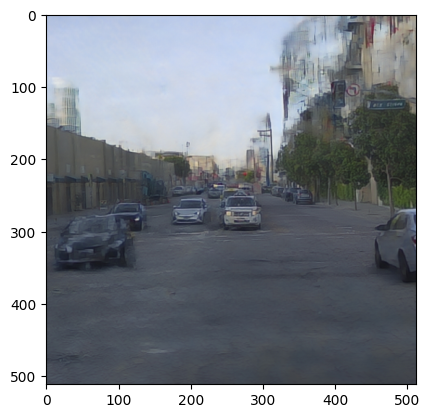

In [61]:
#ex_img_path = Path("data/pandaset/001/camera/front_camera/00.jpg")
ex_img_path = Path("/home/s0001900/dev/neurad-studio/reference/pandaset-01/renders/8m/01.jpg")

img_transform = tvtf.Compose((tvtf.ConvertImageDtype(torch.float32), tvtf.CenterCrop((1024, 1024)), tvtf.Resize((512, 512))))
example_image = read_image(ex_img_path, img_transform)
print(example_image.shape)
plt.imshow(example_image.permute(1, 2, 0))

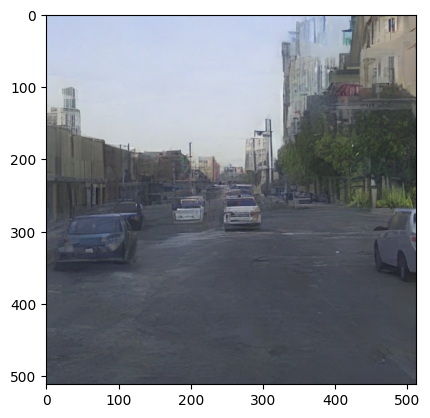

In [92]:
example_input = {"rgb": example_image}
example_output = pipe.get_diffusion_output(example_input, strength=0.3, num_steps=50, denoising_start=0.2, denoising_end=1.1)
plt.imshow(example_output["rgb"].permute(0, 2, 3, 1)[0].float().detach().cpu())

In [101]:
import itertools as it

sweep_vals = {
    "strength": [0.1, 0.2, 0.3],
    "num_steps": [30, 50],
    "denoising_start": [0.0, 0.1, 0.2],
    "denoising_end": [1.0, 1.1, 1.2]
}

sweep_params = list(it.product(*sweep_vals.values()))
sweep_kwargs = [{k:v for k,v in zip(sweep_vals.keys(), params)} for params in sweep_params]
sweep_outputs = []
for i, kwargs in enumerate(sweep_kwargs):
    print(i, '/', len(sweep_kwargs))
    sweep_output = pipe.get_diffusion_output(example_input, **kwargs)
    sweep_outputs.append(sweep_output)

0 / 54
1 / 54
2 / 54
3 / 54
4 / 54
5 / 54
6 / 54
7 / 54
8 / 54
9 / 54
10 / 54
11 / 54
12 / 54
13 / 54
14 / 54
15 / 54
16 / 54
17 / 54
18 / 54
19 / 54
20 / 54
21 / 54
22 / 54
23 / 54
24 / 54
25 / 54
26 / 54
27 / 54
28 / 54
29 / 54
30 / 54
31 / 54
32 / 54
33 / 54
34 / 54
35 / 54
36 / 54
37 / 54
38 / 54
39 / 54
40 / 54
41 / 54
42 / 54
43 / 54
44 / 54
45 / 54
46 / 54
47 / 54
48 / 54
49 / 54
50 / 54
51 / 54
52 / 54
53 / 54


In [108]:
device = pipe.pipe.device

metrics = {
    "psnr": PeakSignalNoiseRatio(data_range=(0, 1.0)).to(device),
    "ssim": StructuralSimilarityIndexMeasure(data_range=(0.0, 1.0)).to(device),
    "mse": nn.MSELoss().to(device)
}

metric_vals = []

with torch.no_grad():
    for sweep_output in sweep_outputs:
        metric_val = [metric(sweep_output["rgb"].to(device).float(), example_input["rgb"][None, ...].to(device)) for metric_name, metric in metrics.items()]
        metric_vals.append(metric_val) 


In [ ]:
metric